In [2]:
from util import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

runtime_df = pd.read_parquet(f"{RUNTIME_DIR}/all_gpus_preprocessed.parquet")
gpu_mapping = {'2080': '2080Ti', '1080': '1080Ti', 'a40': 'A40', 'p100': 'P100', 'v100': 'V100'}

runtime_df = runtime_df[(runtime_df.dataset_type == 'synthetic') & (~runtime_df.operator.isin(['Noop', 'Materialization']))]
runtime_df.GPU = runtime_df.GPU.astype(str).apply(lambda x: gpu_mapping[x])
runtime_df.head()

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,GPU,complexity_ratio,...,nnz_S,r_T,c_T,sparsity_T,sparsity_S,morpheusfi_p,morpheusfi_q,morpheusfi_eis,morpheusfi_ns,morpheusfi_nis
index,,,,,,,,,,,,,,,,,,,,,
5,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,15.570575,Left multiply,-1,1.05385,100000,105385,preset,2080Ti,6.735594,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
6,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,27.106514,Left multiply,-1,1.05385,100000,105385,preset,1080Ti,6.735594,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
7,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.227208,Left multiply,-1,1.05385,100000,105385,preset,A40,6.735594,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
8,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,31.928589,Left multiply,-1,1.05385,100000,105385,preset,P100,6.735594,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
9,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.233145,Left multiply,-1,1.05385,100000,105385,preset,V100,6.735594,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'


## Data & Model Characteristics

Ideas
 - Complexity ratio vs performance ratio, broken down by X

<Axes: xlabel='comp_ratio', ylabel='speedup'>

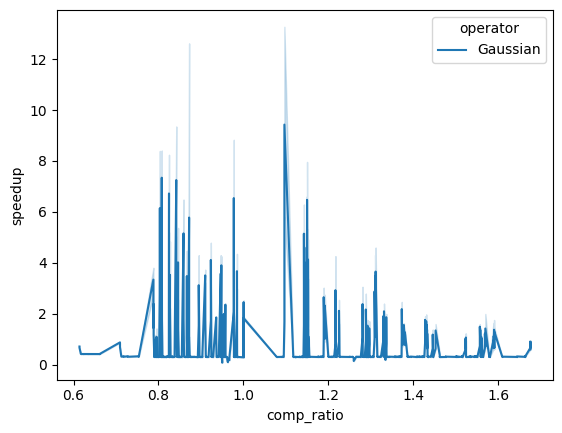

In [3]:
# sns.catplot(data=runtime_df[runtime_df.operator.isin(MODEL_OPERATORS)][:1000], x='comp_ratio', y='speedup', kind='point', col='operator')
sns.lineplot(data=runtime_df[runtime_df.operator =='Gaussian'][:10000], x='comp_ratio', y='speedup', hue='operator')


In [4]:
runtime_df.speedup.describe()

count    193086.000000
mean          0.453411
std           1.027717
min           0.001022
25%           0.072547
50%           0.215914
75%           0.318450
max          31.928589
Name: speedup, dtype: float64

In [5]:
runtime_df['complexity_rounded'] = runtime_df.complexity_ratio.apply(lambda x: round((x * 2), 0)/2)
runtime_df['TR_rounded'] = runtime_df.TR.apply(lambda x: round((x /4), 0)*2)
runtime_df['FR_rounded'] = runtime_df.FR.apply(lambda x: round((x *2), 0)/2)
runtime_df['speedup_rounded'] = runtime_df.speedup.apply(lambda x: round(x / 10, 0) * 10).clip(upper=3)

In [6]:
runtime_df.columns

Index(['dataset', 'speedup', 'operator', 'num_cores', 'selectivity',
       'cardinality_T', 'cardinality_S', 'join', 'GPU', 'complexity_ratio',
       'dataset_type', 'label', 'features', 'parallelism', 'mem_mat_read',
       'mem_mat_write', 'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat',
       'comp_lmm_mat', 'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac',
       'comp_rmm_fac', 'comp_mat_col_major', 'comp_fac_col_major',
       'comp_scalar_dense', '13', '14', 'comp_matrix_dense',
       'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis

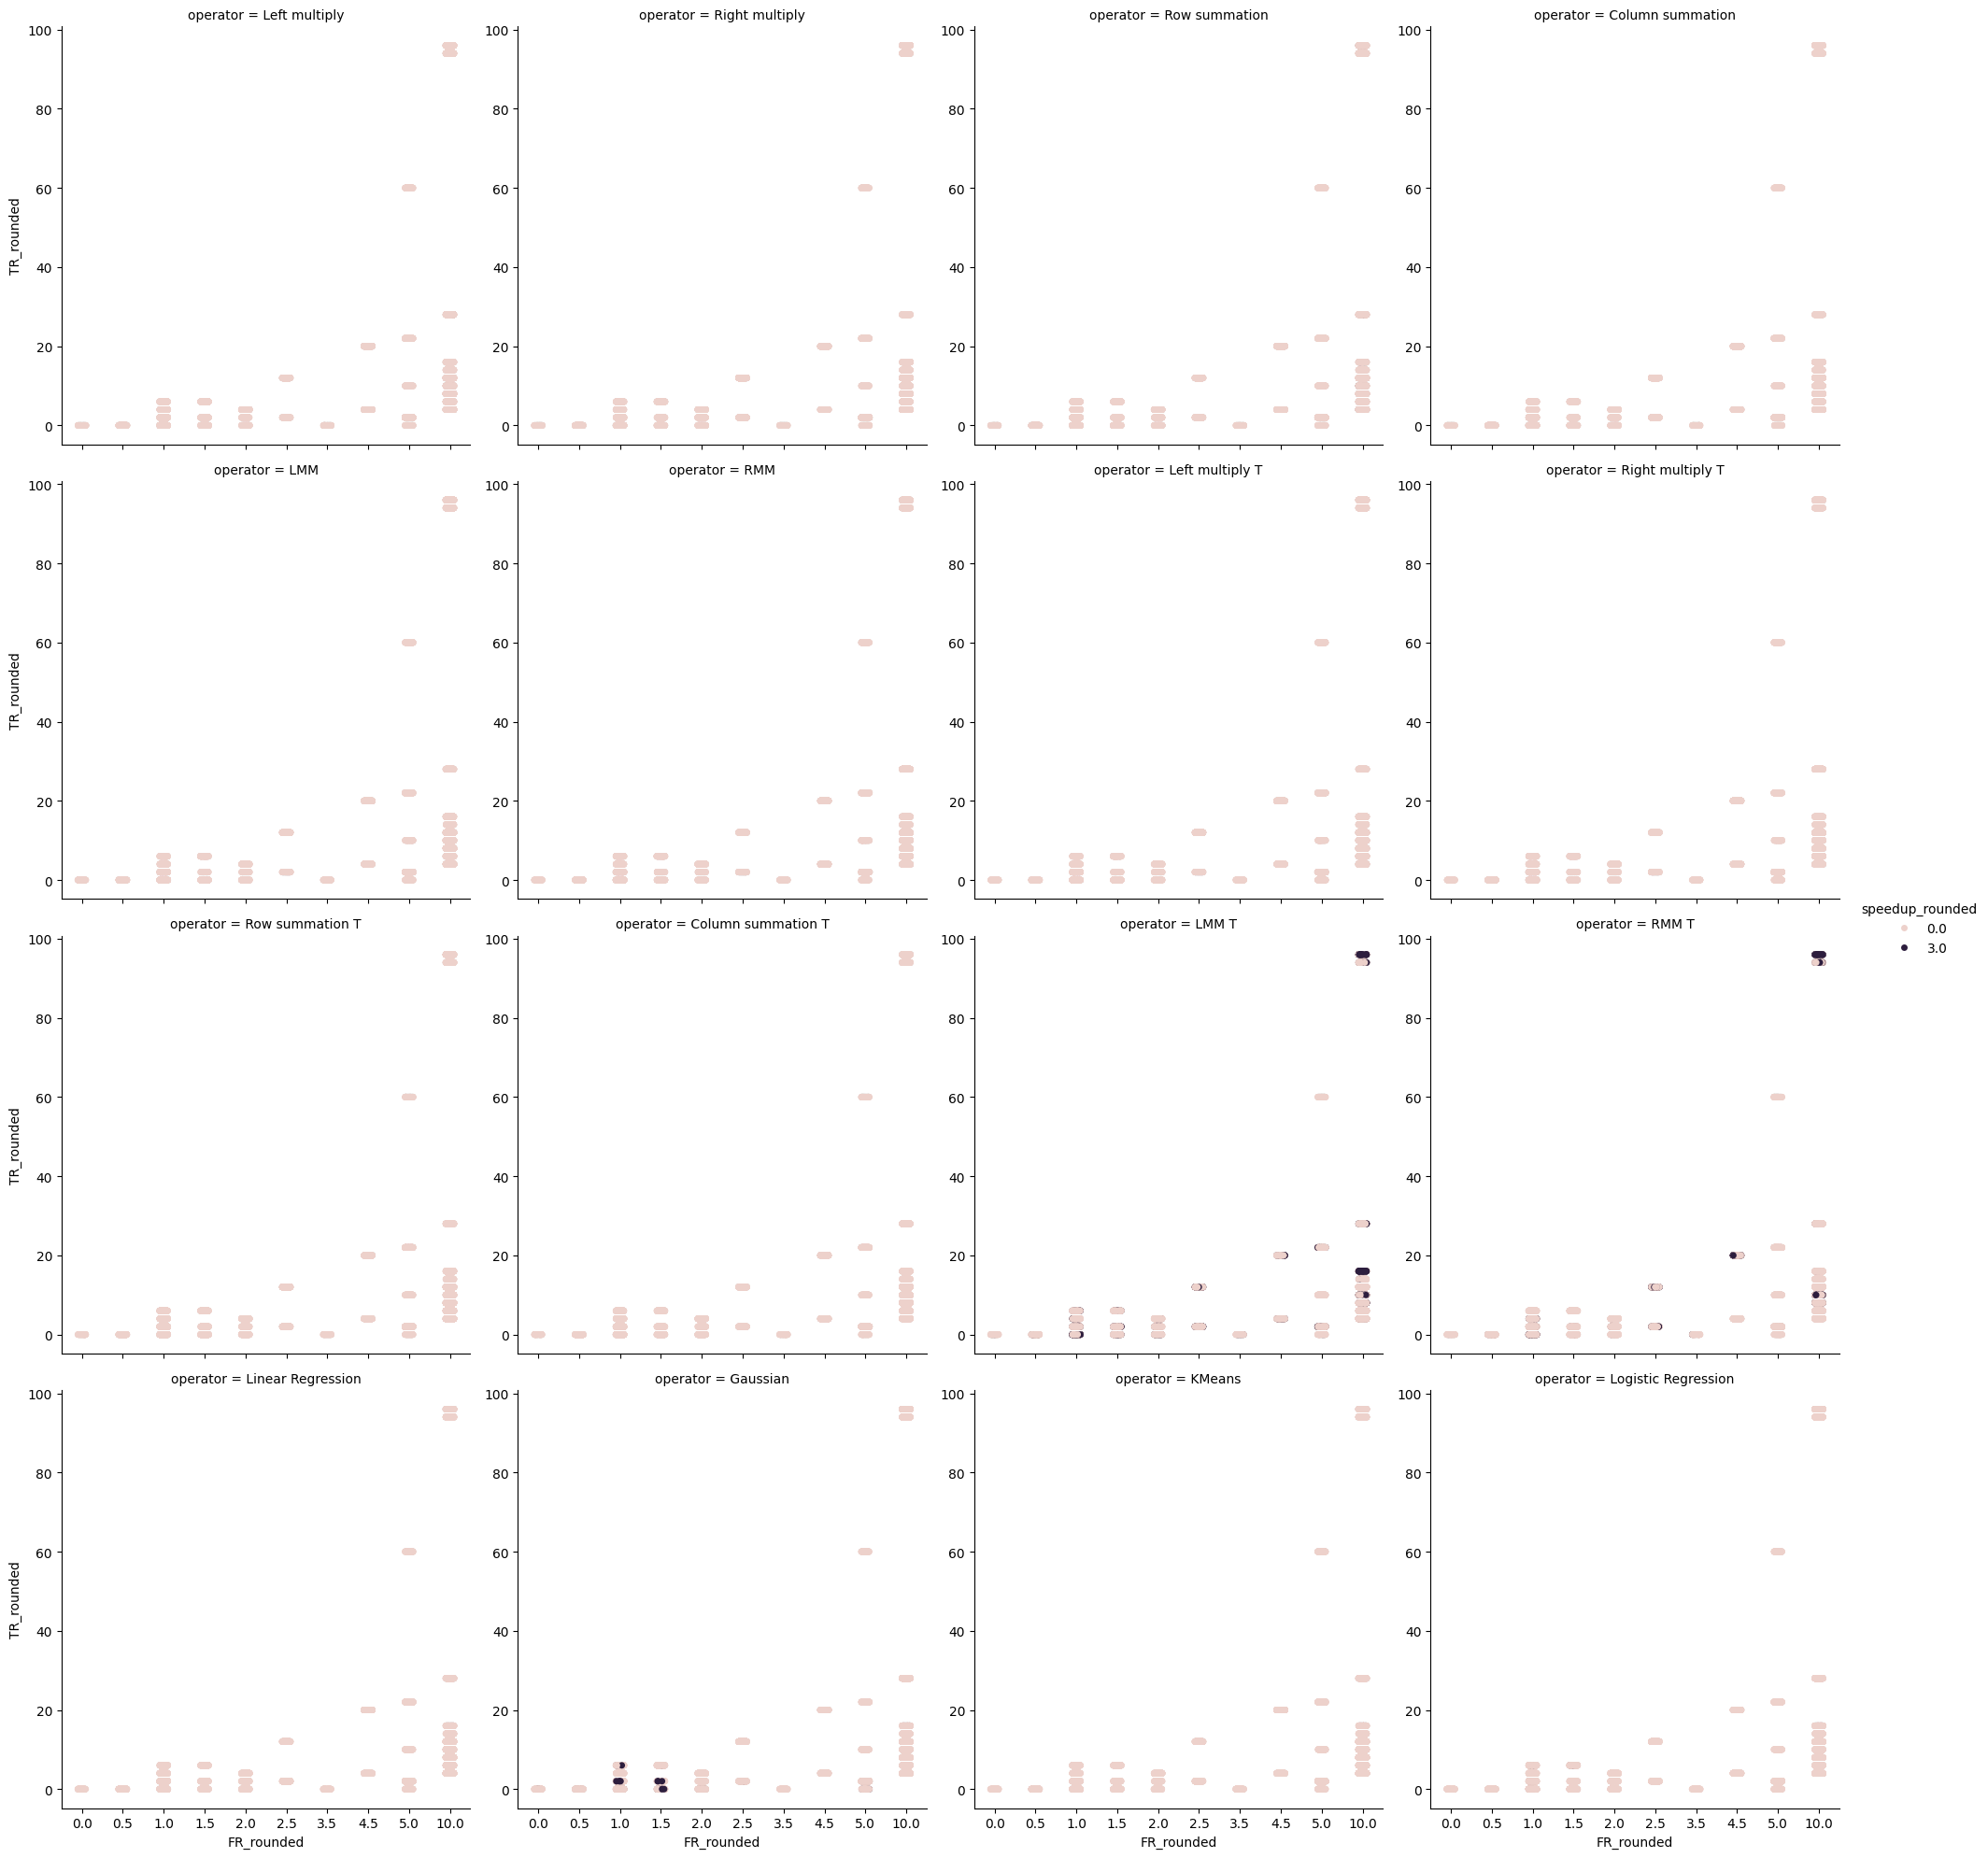

In [7]:
sns.catplot(
    data=runtime_df,
    x="FR_rounded",
    y="TR_rounded",
    col="operator",
    col_wrap=4,
    sharex=True,
    sharey=False,
    kind='strip',
    hue='speedup_rounded'
)

## Hardware Characteristics

In [8]:
from io import StringIO


df = pd.read_csv("./tables/gpu-metrics/gpu-metrics.tsv", delimiter="\t", thousands=",")

df.fillna("", inplace=True)
df["characteristic"] = df.apply(
    lambda row: row["Group"].lower().replace(" ", "_") + "." + row["Characteristic"].lower().replace(" ", "_"), axis=1
).apply(lambda x: x[1:] if x.startswith(".") else x)
df.drop(columns=["Group", "Characteristic", "Unit"], inplace=True)
df = df.T
df.columns = df.tail(1).values[0]
df = df[:-1]
df.index.name = "GPU"
gpu_chars = pd.read_csv(StringIO(df.to_csv()), thousands=",")
gpu_chars.GPU = gpu_chars.GPU.astype(str)
gpu_chars

,GPU,architecture,number_of_sm,cores,cache_size.l1,cache_size.l2,clock_speed.base,clock_speed.max_boost,memory.bus_width,memory.size,memory.clock,memory.bandwidth,processing_power.half_precision,processing_power.single_precision,processing_power.double_precision
0,P100,Pascal,56,3584,24,4.0,1126,1303,4096,16,1430,732,21.20,10.60,5.30
1,1080Ti,Pascal,28,3584,48,2.8,1480,1582,352,11,11000,484,0.17,10.61,0.33
2,V100,Volta,80,5120,128,6.2,1230,1370,4096,32,1750,900,112.22,14.03,7.01
3,2080Ti,Turing,68,4352,64,5.5,1350,1545,352,11,14000,616,23.50,11.75,0.32
4,1660Ti,Turing,24,1536,64,1.5,1500,1770,192,6,12000,288,9.22,4.61,0.14
5,A40,Ampere,84,10752,128,6.0,1305,1740,384,48,7248,696,149.68,37.42,1.17


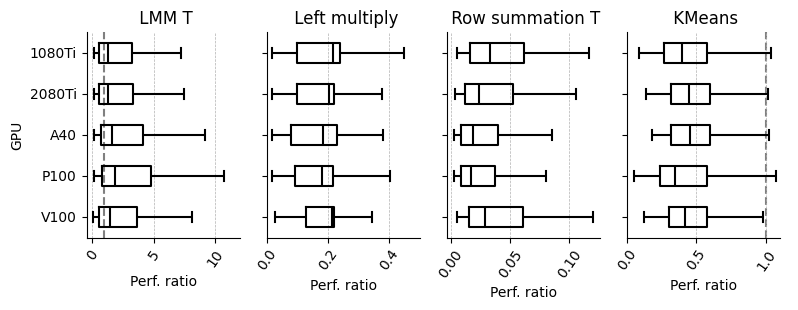

In [9]:
df = runtime_df.merge(gpu_chars, on="GPU")
df = df[df.dataset.str.contains("/mnt/")]
df = df[~df.operator.isin(["Noop", "Materialization"])]
operators = ["LMM T", "Left multiply", 'Row summation T', "KMeans"]

df.sort_values(by='GPU', ascending=True, inplace=True)
facet_grid = sns.catplot(
    data=df[df.operator.isin(operators)],
    kind="box",
    x="speedup",
    y="GPU",
    col="operator",
    # col_wrap=5,
    # height=2.5,
    # aspect=0.7,
    sharex=False,
    sharey=True,
    fill=False,
    fliersize=0,
    color="black",
    width=0.5,
    col_order=["LMM T", "Left multiply", 'Row summation T', "KMeans"],
    zorder=2
)
facet_grid.tick_params(axis="x", rotation=55)
axes = facet_grid.axes.flatten()

facet_grid.set_axis_labels("Perf. ratio", "GPU")
for i, ax in enumerate(axes):
    ax.set_title(ax.get_title().split("=")[1])
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
    if i == 1:
        ax.set_xlim(0, 0.5)
        
    if i == 3: 
        ax.set_xlim(0, 1.1)
    
    if i in [0, 3]:
        ax.axvline(1.0, linestyle='--', color='grey', zorder=1)
                
        
fig = facet_grid.figure
fig.set_size_inches(FIGURE_WIDTH_INCHES, FIGURE_WIDTH_INCHES/2.5)
fig.tight_layout()
facet_grid.savefig(f"{LATEX_PROJECT_BASE_PATH}/chapters/05_cost_estimation/figures/motivation_speedup_per_operator_per_gpu.pdf", bbox_inches="tight")

In [22]:
df["speedup_gte_1"] = df.speedup > 1.0
avg_speedup_df = df[(df.speedup_gte_1 & df.operator.isin(MODEL_OPERATORS))].groupby(["GPU"]).agg({"speedup": ["mean", "count", "std"]})
# avg_speedup_df.speedup['mean'] = avg_speedup_df.speedup['mean']
avg_speedup_df = avg_speedup_df.reindex(columns=[("speedup", "mean"), ("speedup", "std"), ("speedup", "count")]).speedup.reset_index()

display(avg_speedup_df)
table = (
    avg_speedup_df.to_latex(float_format="%.2f", index=False)
    .replace(" & \multicolumn{3}{r}{speedup} \\\n", "")
    .replace("mean", "Mean")
    .replace("std", "Std. Dev.")
    .replace("count", "Count")
    .replace("GPU", "GPU")
    .replace("\midrule", "\midrule\midrule")
    .replace("GPU &  &  &  \\\\\n", "")
)
save_table(table, "chapters/05_cost_estimation/figures/speedup_per_gpu.tex")

,GPU,mean,std,count
0,1080Ti,2.267552,1.591199,434
1,2080Ti,1.855076,1.082839,429
2,A40,2.012200,1.214720,390
3,P100,2.514418,1.859170,464
4,V100,1.939660,1.119690,407


\begin{tabular}{lrrr}
\toprule
GPU & Mean & Std. Dev. & Count \\
\midrule\midrule
1080Ti & 2.27 & 1.59 & 434 \\
2080Ti & 1.86 & 1.08 & 429 \\
A40 & 2.01 & 1.21 & 390 \\
P100 & 2.51 & 1.86 & 464 \\
V100 & 1.94 & 1.12 & 407 \\
\bottomrule
\end{tabular}



In [20]:
avg_speedup_df_operator = df[(df.operator.isin(["LMM T", "Left multiply", "Row summation T"])) & (df.GPU.isin(["V100", "P100"]))].groupby(["GPU", 'operator']).agg({"speedup": ["mean", "count", "std"]})
display(avg_speedup_df_operator.round(3))

speedup             
                        mean count    std
GPU  operator                            
P100 LMM T             3.032  2415  2.695
     Left multiply     0.172  2415  0.653
     Row summation T   0.026  2415  0.023
V100 LMM T             2.323  2415  2.210
     Left multiply     0.213  2415  0.925
     Row summation T   0.040  2415  0.029